In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn 모듈 임포트
from sklearn.model_selection import train_test_split # GridSearchCV 제외
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# LightGBM 임포트
try:
    from lightgbm import LGBMClassifier
    print("LightGBM 라이브러리를 성공적으로 임포트했습니다.")
except ImportError:
    print("경고: lightgbm 라이브러리를 찾을 수 없습니다.")
    LGBMClassifier = None

# XGBoost 임포트
try:
    from xgboost import XGBClassifier
    print("XGBoost 라이브러리를 성공적으로 임포트했습니다.")
except ImportError:
    print("경고: xgboost 라이브러리를 찾을 수 없습니다.")
    XGBClassifier = None

# 한글 폰트 설정
import koreanize_matplotlib
from matplotlib import rcParams
rcParams['axes.unicode_minus'] = False
print("koreanize_matplotlib 로드 완료")

# tqdm pandas 통합 활성화
tqdm.pandas()

# Mecab 또는 Okt 초기화
from mecab import MeCab
mecab = MeCab()
print("Mecab 초기화 완료.")

c:\Users\qwg52\.conda\envs\env312_cpu_v1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LightGBM 라이브러리를 성공적으로 임포트했습니다.
XGBoost 라이브러리를 성공적으로 임포트했습니다.
koreanize_matplotlib 로드 완료
Mecab 초기화 완료.


In [5]:
# 불용어 목록 정의
stop_words_list = [
    # '동대구역', '위', '입구', '동대', '구역', '인근', '주자', '공간', '앞', '뒤', '안', '옆', '근처', '주변', '가까운', '지역', '골목',
    # '친절', '덕분', '기분', '좋', '인상', '만족', '강추', '최애', '영접', '소문', '사실', '참한', '맛있', '최고', '추천',
    # '검색', '때', '제공', '기본', '찬', '경우', '있', '겉', '속', '전반', '성비', '곳', '가능', '같', '손', '에너지',
    # '인사', '모습', '여행', '차', '없', '손님', '많', '사장', '지친', '더보기', '방문', '다음', '말', '시간', '후',
    # '분위기', '사람', '처음', '생각', '리뷰', '완전', '편하다', '점', '느낌',
    # '맛있다', '맛집', '맛', '굿', '짱', '괜찮다',
    # '주문', '집', '매장', '식사', '가격', '서비스', '포장', '주방', '식당', '메뉴', '음식',
    # '담', '간', '층', '전', '날', '동', '월', '요', '수', '표', '무', '것', '끝', '직', '등', '함', '또',
    # '다', '별거', '아쉽', '종가', '높', '보통', '가위', '그만큼', '바보', '신세계백화점', '대구', '리회', '레기' , '기존'
]
stop_words = set(stop_words_list)

def stem_processing(text):
    if not isinstance(text, str) or not text.strip(): return ""
    try:
        pos_data = mecab.pos(text)
        result = []
        target_tags = {'NNG', 'NNP'}
        for word, tag in pos_data:
            if word in stop_words: continue
            if tag in target_tags:
                result.append(word)
            elif tag == 'VA':
                processed_word = word + "다"
                if processed_word not in stop_words:
                    result.append(processed_word)
        return " ".join(result)
    except Exception as e:
        return ""

print("stem_processing 함수 정의 완료.")

stem_processing 함수 정의 완료.


In [10]:
# 1. 데이터 로드
# !!! 실제 파일 경로로 수정하세요 !!!
file_path = 'final_dataset_2.csv' 
df = pd.read_csv(file_path, index_col=0)
if df.columns[0] == ',': df = pd.read_csv(file_path, index_col=0)
print(f"'{file_path}' 로드 완료 (형태: {df.shape}).")

# 2. 기본 전처리
if 'REVIEW' in df.columns: df['REVIEW'] = df['REVIEW'].fillna('')
if 'WAIT_encoded' in df.columns:
    condition = df['WAIT_encoded'] == 5.0
    original_count = condition.sum()
    if original_count > 0:
         df.loc[condition, 'WAIT_encoded'] = 0.0
         print(f"'WAIT_encoded' 컬럼에서 {original_count}개의 5.0 값을 0.0으로 변경.")
numerical_cols_to_check = ['VISIT_COUNT', 'VISITOR_REVIEW_NUM', 'WAIT_encoded']
for col in numerical_cols_to_check:
    if col in df.columns and df[col].isnull().any():
        mean_val = df[col].mean()
        print(f"경고: '{col}' 컬럼 결측치를 평균값({mean_val:.2f})으로 대체.")
        df[col] = df[col].fillna(mean_val)
print("\n기본 전처리 완료.")

'final_dataset_2.csv' 로드 완료 (형태: (7958, 43)).

기본 전처리 완료.


In [11]:
df.head()

,STORE_NAME,REVIEW,TIME_밤에 방문,TIME_아침에 방문,TIME_저녁에 방문,TIME_점심에 방문,WAIT_encoded,HOW_예약 없이 이용,HOW_예약 후 이용,HOW_포장·배달 이용,...,매장이 넓어요,특별한 메뉴가 있어요,고기 질이 좋아요,인테리어가 멋져요,혼밥하기 좋아요,단체모임 하기 좋아요,주차하기 편해요,메뉴 구성이 알차요,직접 잘 구워줘요,CATEGORY
0,1호스시,초밥부터 돈까스까지 뭐하나 빠짐없이 맛있습니다\n사장님도 너무너무 친절하시고 늘 만...,False,False,True,False,0.0,True,False,False,...,0,0,0,0,0,0,0,0,0,아시아/해산물
1,1호스시,연어초밥 못 먹을 뻔 했는데 다행히 주문 가능했어요!!\n여전히 두툼하구 너무 맛있...,False,False,True,False,0.0,True,False,False,...,0,0,0,0,0,0,0,0,0,아시아/해산물
2,1호스시,오랜만에 매장에서 먹었는데 역시 너무 맛있어요,False,False,True,False,0.0,True,False,False,...,0,0,0,0,0,0,0,0,0,아시아/해산물
3,1호스시,사무실 야근하면서 시켜 먹었는데 맛은 있어요\n조밥안에 밥양도 적당 하구요..살짝 ...,False,False,True,False,1.0,False,False,True,...,0,0,0,0,1,0,0,0,0,아시아/해산물
4,1호스시,맛있는 초밥 친절한 사장님,False,False,False,True,0.0,True,False,False,...,0,0,0,0,1,0,0,0,0,아시아/해산물


In [74]:
# 3. 형태소 분석 및 불용어 제거 적용
if 'REVIEW' in df.columns:
    print("\n리뷰 텍스트 전처리 시작 (stem_processing 적용)...")
    df['PROCESSED_REVIEW'] = df['REVIEW'].progress_apply(stem_processing)
    print("리뷰 텍스트 전처리 완료.")
else:
     print("\n리뷰 컬럼이 없어 텍스트 전처리를 건너뜁니다.")
     df['PROCESSED_REVIEW'] = ""


리뷰 텍스트 전처리 시작 (stem_processing 적용)...


100%|██████████| 7958/7958 [00:01<00:00, 6125.71it/s]

리뷰 텍스트 전처리 완료.


In [75]:
# 4. 사용할 특징 컬럼 정의
text_feature = 'PROCESSED_REVIEW'
target_column = 'CATEGORY'
numerical_features = [col for col in ['WAIT_encoded'] if col in df.columns] #  'VISIT_COUNT', 'VISITOR_REVIEW_NUM',
categorical_prefixes = ['HOW_', 'TIME_', 'PURPOSE_', 'WITH_WHOM_']
categorical_features = [col for col in df.columns if any(col.startswith(prefix) for prefix in categorical_prefixes)]
keyword_features = []
try:
    possible_keywords = ['음식이 맛있어요', '친절해요', '재료가 신선해요', '양이 많아요', '가성비가 좋아요',
                         '매장이 청결해요', '매장이 넓어요', '특별한 메뉴가 있어요', '고기 질이 좋아요', '인테리어가 멋져요']
    keyword_features = [col for col in possible_keywords if col in df.columns]
except Exception as e: print(f"키워드 컬럼 식별 중 오류: {e}.")

feature_columns = numerical_features + categorical_features + keyword_features
if text_feature in df.columns: feature_columns.insert(0, text_feature)
else: print(f"경고: 텍스트 특징 컬럼 '{text_feature}'이 없어 제외됩니다.")

missing_cols = [col for col in feature_columns + [target_column] if col not in df.columns]
if missing_cols: raise KeyError(f"Missing required columns: {missing_cols}")
if not feature_columns: raise ValueError("No feature columns defined.")

# 5. 특징(X)과 타겟(y) 분리
X = df[feature_columns]
y = df[target_column]
print(f"\n특징(X)으로 사용할 컬럼 수: {len(feature_columns)}")
print(f"타겟(y) 컬럼: {target_column}")
print("\n원본 데이터 타겟 분포:")
print(y.value_counts().sort_index())

# 6. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n데이터 분할 완료: 학습 {X_train.shape[0]}개, 테스트 {X_test.shape[0]}개")
print("\n분할 후 학습 데이터 카테고리 분포:")
print(y_train.value_counts().sort_index())


특징(X)으로 사용할 컬럼 수: 36
타겟(y) 컬럼: CATEGORY

원본 데이터 타겟 분포:
CATEGORY
고기          1215
분식/패스트푸드     300
술집           152
아시아/해산물      903
양식/카페        424
쭈꾸미         1517
찌개/면류       1682
한식          1765
Name: count, dtype: int64

데이터 분할 완료: 학습 6366개, 테스트 1592개

분할 후 학습 데이터 카테고리 분포:
CATEGORY
고기           972
분식/패스트푸드     240
술집           122
아시아/해산물      722
양식/카페        339
쭈꾸미         1214
찌개/면류       1345
한식          1412
Name: count, dtype: int64


In [76]:
# 7. 특징 공학 파이프라인 정의
transformers_list = []
tfidf_params = {'max_df': 0.95, 'min_df': 3, 'max_features': 5000, 'ngram_range': (1, 2)}
if text_feature in feature_columns:
    tfidf_vectorizer = TfidfVectorizer(**tfidf_params)
    transformers_list.append(('tfidf', tfidf_vectorizer, text_feature))
if numerical_features:
    numeric_transformer = StandardScaler()
    transformers_list.append(('numeric', numeric_transformer, numerical_features))
if categorical_features:
    transformers_list.append(('categorical', 'passthrough', categorical_features))
if keyword_features:
    transformers_list.append(('keywords', 'passthrough', keyword_features))

if transformers_list:
    preprocessor = ColumnTransformer(transformers=transformers_list, remainder='drop', n_jobs=-1)
    print("\nColumnTransformer 정의 완료.")
else:
    raise ValueError("No transformers defined for ColumnTransformer.")


ColumnTransformer 정의 완료.


In [77]:
# 8. 데이터 변환 (학습/테스트 데이터 모두)
print("\n데이터 변환 시작 (ColumnTransformer 적용)...")
X_train_processed = preprocessor.fit_transform(X_train)
print(f"변환된 학습 데이터 형태: {X_train_processed.shape}")
X_test_processed = preprocessor.transform(X_test)
print(f"변환된 테스트 데이터 형태: {X_test_processed.shape}")

# --- SMOTE 적용 안 함 ---

# 9. VotingClassifier 정의 및 학습 (GridSearchCV 없이, XGBoost 포함)
print("\nVotingClassifier 정의 및 학습 시작 (GridSearchCV 없이, XGBoost 포함)...")

# 9-1. 기본 모델 정의 (고정된 하이퍼파라미터 사용)
# !!! 각 모델의 파라미터는 이전 튜닝 결과나 경험 기반으로 설정 !!!
estimators = []

# 모델 1: Logistic Regression (예: 이전 튜닝 최적값 또는 합리적 값)
clf1 = LogisticRegression(C=1.0, solver='liblinear', random_state=42, max_iter=1500, n_jobs=-1)
estimators.append(('lr', clf1))
print(f"Base model 1: Logistic Regression (C={clf1.C}, solver={clf1.solver})")

# 모델 2: RandomForestClassifier (예: 이전 튜닝 최적값 또는 합리적 값)
clf2 = RandomForestClassifier(n_estimators=250, max_depth=None, min_samples_split=5,
                              min_samples_leaf=2, random_state=42, n_jobs=-1)
estimators.append(('rf', clf2))
print(f"Base model 2: RandomForest (n_estimators={clf2.n_estimators}, min_samples_split={clf2.min_samples_split}, min_samples_leaf={clf2.min_samples_leaf})")

# 모델 3: LGBMClassifier (설치된 경우, 예: 합리적 기본값)
if LGBMClassifier:
    clf3 = LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=31,
                          random_state=42, n_jobs=-1)
    estimators.append(('lgbm', clf3))
    print(f"Base model 3: LGBM (n_estimators={clf3.n_estimators}, learning_rate={clf3.learning_rate})")

# 모델 4: XGBClassifier (설치된 경우, 예: 합리적 기본값)
if XGBClassifier:
    clf4 = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss',
                         n_estimators=150, learning_rate=0.1, max_depth=5, # 예시 파라미터
                         use_label_encoder=False, random_state=42, n_jobs=-1)
    estimators.append(('xgb', clf4))
    print(f"Base model 4: XGBoost (n_estimators={clf4.n_estimators}, learning_rate={clf4.learning_rate}, max_depth={clf4.max_depth})")


# 9-2. VotingClassifier 생성
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft', # Soft voting 사용
    n_jobs=-1     # 개별 모델 학습 병렬 처리
)
print(f"\nVotingClassifier 생성 완료 (방식: {voting_clf.voting})")

# 9-3. VotingClassifier 학습
print("VotingClassifier 학습 시작...")
# SMOTE 미적용된 원본 학습 데이터 사용
voting_clf.fit(X_train_processed, y_train)
print("VotingClassifier 학습 완료.")

# 최종 모델을 'model' 변수에 할당
model = voting_clf


데이터 변환 시작 (ColumnTransformer 적용)...
변환된 학습 데이터 형태: (6366, 2379)
변환된 테스트 데이터 형태: (1592, 2379)

VotingClassifier 정의 및 학습 시작 (GridSearchCV 없이, XGBoost 포함)...
Base model 1: Logistic Regression (C=1.0, solver=liblinear)
Base model 2: RandomForest (n_estimators=250, min_samples_split=5, min_samples_leaf=2)
Base model 3: LGBM (n_estimators=200, learning_rate=0.1)
Base model 4: XGBoost (n_estimators=150, learning_rate=0.1, max_depth=5)

VotingClassifier 생성 완료 (방식: soft)
VotingClassifier 학습 시작...
VotingClassifier 학습 완료.


In [78]:
# 11. 모델 평가 (원본 테스트 데이터 사용)
print("\n모델 평가 시작 (원본 테스트 데이터 기준)...")
try:
    if 'model' not in locals() or 'X_test_processed' not in locals() or 'y_test' not in locals():
         raise NameError("Model or processed test data is not defined.")

    y_pred = model.predict(X_test_processed) # VotingClassifier로 예측
    accuracy = accuracy_score(y_test, y_pred)

except NameError as e: raise e
except Exception as e: raise e


모델 평가 시작 (원본 테스트 데이터 기준)...


c:\Users\qwg52\.conda\envs\env312_cpu_v1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [79]:

# 방법 명시하여 출력
print(f"\n테스트 데이터 정확도 (Voting Ensemble): {accuracy:.4f}")

print("\n분류 리포트:")
unique_categories = sorted(list(set(y_test) | set(y_pred)))
report_dict = classification_report(y_test, y_pred, labels=unique_categories, output_dict=True, zero_division=0)
print(classification_report(y_test, y_pred, labels=unique_categories, zero_division=0))


테스트 데이터 정확도 (Voting Ensemble): 0.5747

분류 리포트:
              precision    recall  f1-score   support

          고기       0.85      0.83      0.84       243
    분식/패스트푸드       0.90      0.15      0.26        60
          술집       0.65      0.37      0.47        30
     아시아/해산물       0.69      0.46      0.55       181
       양식/카페       0.72      0.51      0.59        85
         쭈꾸미       0.47      0.71      0.57       303
       찌개/면류       0.56      0.42      0.48       337
          한식       0.48      0.59      0.53       353

    accuracy                           0.57      1592
   macro avg       0.66      0.50      0.54      1592
weighted avg       0.61      0.57      0.57      1592



In [80]:
print("\n혼동 행렬:")
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_categories)
# 시각화를 위해 결과 저장
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_categories, columns=unique_categories)
print(conf_matrix_df)


혼동 행렬:
           고기  분식/패스트푸드  술집  아시아/해산물  양식/카페  쭈꾸미  찌개/면류   한식
고기        202         0   1        3      3   18      3   13
분식/패스트푸드    0         9   1        2      4   20     10   14
술집          4         0  11        1      0    3      4    7
아시아/해산물    12         0   2       83      1   34     14   35
양식/카페       1         0   0        5     43    9      6   21
쭈꾸미         0         1   1        7      2  216     31   45
찌개/면류       2         0   0       10      2   86    142   95
한식         17         0   1       10      5   69     42  209


In [81]:
# 11.5: 학습된 모델 및 전처리기 저장
print("\n--- 모델 및 전처리기 저장 시작 ---")

# 저장할 파일명 정의
model_filename = 'tuned_voting_model.joblib'
preprocessor_filename = 'preprocessor.joblib'

try:
    # 모델 저장
    joblib.dump(model, model_filename)
    print(f"모델이 성공적으로 '{model_filename}' 파일로 저장되었습니다.")

    # 전처리기 저장
    joblib.dump(preprocessor, preprocessor_filename)
    print(f"전처리기가 성공적으로 '{preprocessor_filename}' 파일로 저장되었습니다.")

except NameError as e:
    print(f"오류: 저장할 객체(model 또는 preprocessor)가 정의되지 않았습니다. 이전 셀 실행을 확인하세요. 오류: {e}")
except Exception as e:
    print(f"파일 저장 중 오류 발생: {e}")

print("--- 저장 완료 ---")


--- 모델 및 전처리기 저장 시작 ---
모델이 성공적으로 'tuned_voting_model.joblib' 파일로 저장되었습니다.
전처리기가 성공적으로 'preprocessor.joblib' 파일로 저장되었습니다.
--- 저장 완료 ---



--- 최종 모델 성능 시각화 ---


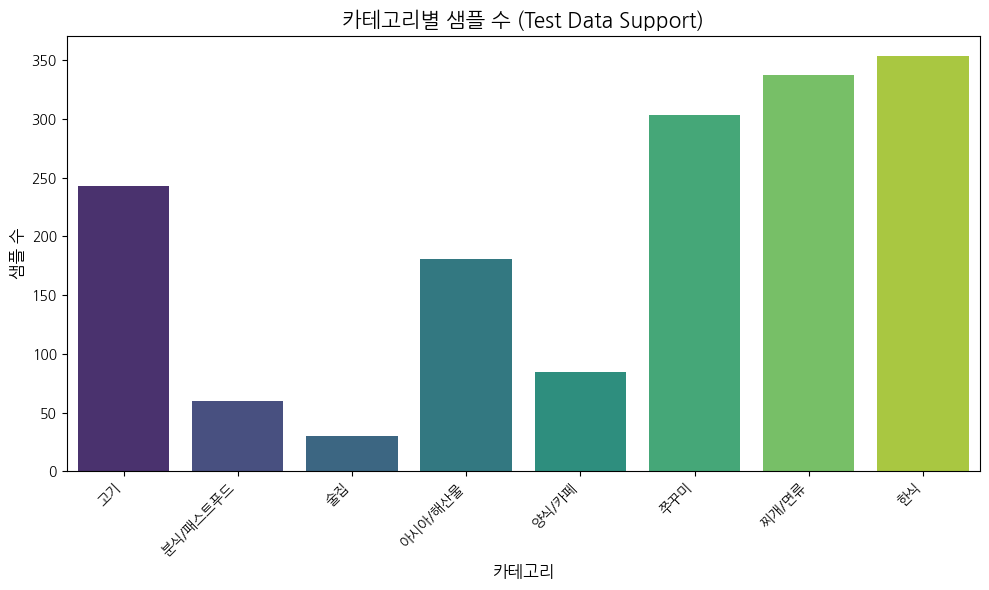

------------------------------


<Figure size 1200x700 with 0 Axes>

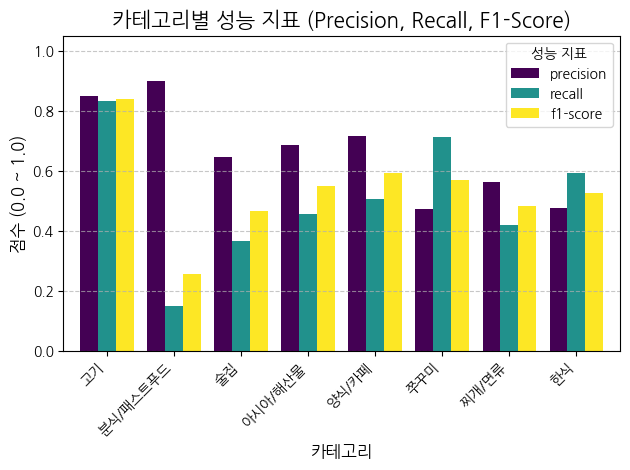

------------------------------


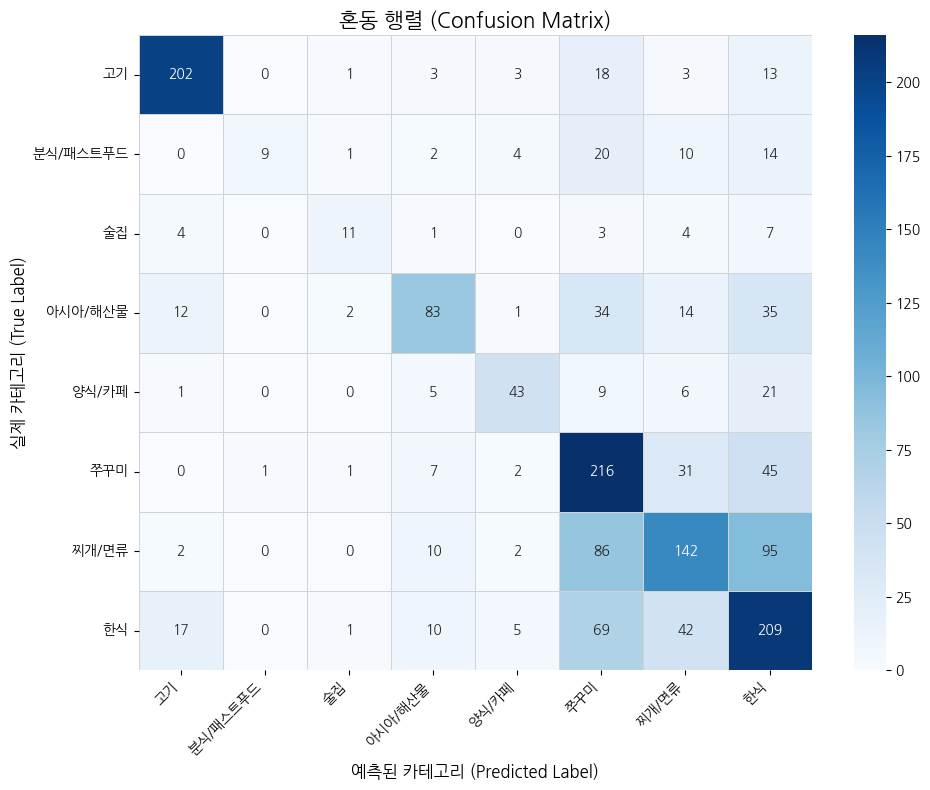

------------------------------


In [82]:
# 13. 시각화 (셀 8의 평가 결과 사용)
print("\n--- 최종 모델 성능 시각화 ---")
try:
    # 셀 8에서 생성된 변수 사용
    if 'y_test' not in locals() or 'y_pred' not in locals() or 'unique_categories' not in locals() or 'conf_matrix_df' not in locals() or 'report_dict' not in locals():
        raise NameError("Evaluation results not found. Run cell 8 first.")

    # --- 1. 카테고리별 샘플 수 (Support) 시각화 ---
    plt.figure(figsize=(10, 6))
    support_data = {label: report_dict[label]['support'] for label in unique_categories if isinstance(report_dict.get(label), dict)}
    category_names = list(support_data.keys())
    support_values = list(support_data.values())
    sns.barplot(x=category_names, y=support_values, hue=category_names, palette='viridis', legend=False)
    plt.title('카테고리별 샘플 수 (Test Data Support)', fontsize=15)
    plt.xlabel('카테고리', fontsize=12)
    plt.ylabel('샘플 수', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print("-" * 30)

    # --- 2. 카테고리별 주요 성능 지표 시각화 ---
    metrics_data = {label: {metric: report_dict[label][metric] for metric in ['precision', 'recall', 'f1-score']}
                    for label in unique_categories if isinstance(report_dict.get(label), dict)}
    metrics_df = pd.DataFrame(metrics_data).T
    plt.figure(figsize=(12, 7))
    metrics_df.plot(kind='bar', width=0.8, colormap='viridis')
    plt.title('카테고리별 성능 지표 (Precision, Recall, F1-Score)', fontsize=15)
    plt.xlabel('카테고리', fontsize=12)
    plt.ylabel('점수 (0.0 ~ 1.0)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.legend(title='성능 지표', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("-" * 30)

    # --- 3. 혼동 행렬 Heatmap 시각화 ---
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='lightgray')
    plt.title('혼동 행렬 (Confusion Matrix)', fontsize=15)
    plt.xlabel('예측된 카테고리 (Predicted Label)', fontsize=12)
    plt.ylabel('실제 카테고리 (True Label)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print("-" * 30)

except NameError as e: print(f"시각화 오류: 필요한 평가 결과 변수가 없습니다. 오류: {e}")
except Exception as e: print(f"시각화 중 오류 발생: {e}")

In [83]:
# 14. 저장된 모델 및 전처리기 로드 및 사용 (다른 사용자/환경 시뮬레이션)
print("\n--- 저장된 모델 및 전처리기 로드 및 사용 예시 ---")

# 로드할 파일명 (저장 시 사용한 이름과 동일)
model_filename_to_load = 'tuned_voting_model.joblib'
preprocessor_filename_to_load = 'preprocessor.joblib'

try:
    # 모델 로드
    loaded_model = joblib.load(model_filename_to_load)
    print(f"'{model_filename_to_load}' 파일에서 모델을 성공적으로 로드했습니다.")
    print(f"로드된 모델 타입: {type(loaded_model)}")

    # 전처리기 로드
    loaded_preprocessor = joblib.load(preprocessor_filename_to_load)
    print(f"'{preprocessor_filename_to_load}' 파일에서 전처리기를 성공적으로 로드했습니다.")
    print(f"로드된 전처리기 타입: {type(loaded_preprocessor)}")

    # --- 로드된 모델 및 전처리기 사용 예시 ---
    # 예시: 테스트 데이터의 첫 5개 샘플에 대해 예측 수행
    # 주의: 실제 사용 시에는 새로운 데이터를 준비해야 함
    print("\n로드된 모델과 전처리기를 사용하여 예측 수행 예시 (테스트 데이터 일부 사용):")

    # 1. 예측할 새로운 데이터 준비 (여기서는 X_test의 일부 사용)
    #    실제로는 새로운 리뷰, 키워드 값 등으로 구성된 DataFrame 준비
    new_data_to_predict = X_test.head() # 테스트 데이터 앞 5개 사용
    print(f"예측할 원본 데이터 (처음 5개):\n{new_data_to_predict}")

    # 2. 로드된 전처리기를 사용하여 데이터 변환 (!!! 중요 !!!)
    new_data_processed = loaded_preprocessor.transform(new_data_to_predict)
    print(f"\n전처리된 데이터 형태: {new_data_processed.shape}")

    # 3. 로드된 모델을 사용하여 예측 수행
    new_predictions = loaded_model.predict(new_data_processed)
    new_probabilities = loaded_model.predict_proba(new_data_processed)

    print("\n예측 결과:")
    for i, pred in enumerate(new_predictions):
        print(f" - 샘플 {i+1}: 예측 카테고리 = {pred}")
        # 상위 예측 확률 확인 (예시)
        top_proba_idx = np.argsort(new_probabilities[i])[-1] # 가장 높은 확률 인덱스
        top_proba_cat = loaded_model.classes_[top_proba_idx]
        print(f"     (가장 높은 확률: {top_proba_cat} - {new_probabilities[i][top_proba_idx]:.4f})")


except FileNotFoundError as e:
    print(f"오류: 저장된 파일을 찾을 수 없습니다. '{e.filename}' 경로를 확인하세요.")
    print("셀 8.5를 먼저 실행하여 파일을 생성해야 합니다.")
except NameError as e:
    print(f"오류: 필요한 변수(X_test 등)가 정의되지 않았습니다. 데모 실행을 위해 이전 셀을 실행하세요. 오류: {e}")
except Exception as e:
    print(f"파일 로드 또는 예측 중 오류 발생: {e}")

print("\n--- 로드 및 사용 예시 완료 ---")


--- 저장된 모델 및 전처리기 로드 및 사용 예시 ---
'tuned_voting_model.joblib' 파일에서 모델을 성공적으로 로드했습니다.
로드된 모델 타입: <class 'sklearn.ensemble._voting.VotingClassifier'>
'preprocessor.joblib' 파일에서 전처리기를 성공적으로 로드했습니다.
로드된 전처리기 타입: <class 'sklearn.compose._column_transformer.ColumnTransformer'>

로드된 모델과 전처리기를 사용하여 예측 수행 예시 (테스트 데이터 일부 사용):
예측할 원본 데이터 (처음 5개):
                         PROCESSED_REVIEW  WAIT_encoded  TIME_밤에 방문  \
7455                                   친절           0.0       False   
2399                              비싸다 맛있다           0.0       False   
2590                                  맛있다           0.0       False   
1123  네이버 우연 생고기 질 가성 갑 맛있다 맛있다 다 맛집 맛 체고           0.0       False   
573                             동대구 국밥 맛집           0.0       False   

      TIME_아침에 방문  TIME_저녁에 방문  TIME_점심에 방문  HOW_예약 없이 이용  HOW_예약 후 이용  \
7455        False         True        False          True        False   
2399        False        False         True          True        False   
2590        F

c:\Users\qwg52\.conda\envs\env312_cpu_v1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\qwg52\.conda\envs\env312_cpu_v1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [84]:
print("\n예측 결과:")
for i, pred in enumerate(new_predictions):
    print(f" - 샘플 {i+1}: 예측 카테고리 = {pred}")
    # 상위 예측 확률 확인 (예시)
    top_proba_idx = np.argsort(new_probabilities[i])[-1] # 가장 높은 확률 인덱스
    top_proba_cat = loaded_model.classes_[top_proba_idx]
    print(f"     (가장 높은 확률: {top_proba_cat} - {new_probabilities[i][top_proba_idx]:.4f})")



예측 결과:
 - 샘플 1: 예측 카테고리 = 한식
     (가장 높은 확률: 한식 - 0.3488)
 - 샘플 2: 예측 카테고리 = 쭈꾸미
     (가장 높은 확률: 쭈꾸미 - 0.2995)
 - 샘플 3: 예측 카테고리 = 찌개/면류
     (가장 높은 확률: 찌개/면류 - 0.4373)
 - 샘플 4: 예측 카테고리 = 고기
     (가장 높은 확률: 고기 - 0.8618)
 - 샘플 5: 예측 카테고리 = 한식
     (가장 높은 확률: 한식 - 0.8088)


In [ ]:
# 불용어 목록 정의
stop_words_list = [
    # '동대구역', '위', '입구', '동대', '구역', '인근', '주자', '공간', '앞', '뒤', '안', '옆', '근처', '주변', '가까운', '지역', '골목',
    # '친절', '덕분', '기분', '좋', '인상', '만족', '강추', '최애', '영접', '소문', '사실', '참한', '맛있', '최고', '추천',
    # '검색', '때', '제공', '기본', '찬', '경우', '있', '겉', '속', '전반', '성비', '곳', '가능', '같', '손', '에너지',
    # '인사', '모습', '여행', '차', '없', '손님', '많', '사장', '지친', '더보기', '방문', '다음', '말', '시간', '후',
    # '분위기', '사람', '처음', '생각', '리뷰', '완전', '편하다', '점', '느낌',
    # '맛있다', '맛집', '맛', '굿', '짱', '괜찮다',
    # '주문', '집', '매장', '식사', '가격', '서비스', '포장', '주방', '식당', '메뉴', '음식',
    # '담', '간', '층', '전', '날', '동', '월', '요', '수', '표', '무', '것', '끝', '직', '등', '함', '또',
    # '다', '별거', '아쉽', '종가', '높', '보통', '가위', '그만큼', '바보', '신세계백화점', '대구', '리회', '레기' , '기존'
]
stop_words = set(stop_words_list)

def stem_processing(text):
    if not isinstance(text, str) or not text.strip(): return ""
    try:
        pos_data = mecab.pos(text)
        result = []
        target_tags = {'NNG', 'NNP'}
        for word, tag in pos_data:
            if word in stop_words: continue
            if tag in target_tags:
                result.append(word)
            elif tag == 'VA':
                processed_word = word + "다"
                if processed_word not in stop_words:
                    result.append(processed_word)
        return " ".join(result)
    except Exception as e:
        return ""

stem_processing 함수 정의 완료.


In [87]:
# 로드할 파일명 (저장 시 사용한 이름과 동일)
model_filename_to_load = 'tuned_voting_model.joblib'
preprocessor_filename_to_load = 'preprocessor.joblib'

try:
    # 모델 로드
    loaded_model = joblib.load(model_filename_to_load)

    # 전처리기 로드
    loaded_preprocessor = joblib.load(preprocessor_filename_to_load)

    # --- 로드된 모델 및 전처리기 사용 ---

    # 1. 예측할 새로운 단일 데이터 준비 (딕셔너리 형태)
    #    실제 상황에 맞는 값으로 수정하여 테스트 가능
    single_example_review = "친구랑 저녁에 방문했는데 고기 질도 좋고 직원분이 친절하게 다 구워주셔서 편하게 먹었어요. 주차도 편해요!"

    single_example_dict = {
        # 텍스트 특징 (stem_processing 함수 필요)
        'PROCESSED_REVIEW': stem_processing(single_example_review),

        # 수치형 특징 (예시 값)
        'WAIT_encoded': 0.0, # 대기 없음

        # 범주형 특징 (예시 값)
        'HOW_예약 없이 이용': True, 'HOW_예약 후 이용': False, 'HOW_정보 없음': False, 'HOW_포장·배달 이용': False,
        'TIME_밤에 방문': False, 'TIME_아침에 방문': False, 'TIME_저녁에 방문': True, 'TIME_점심에 방문': False,
        'PURPOSE_데이트': False, 'PURPOSE_비즈니스': False, 'PURPOSE_가족모임': False, 'PURPOSE_여행': False, 'PURPOSE_나들이': False, 'PURPOSE_기념일': False, 'PURPOSE_친목': True, 'PURPOSE_회식': False, 'PURPOSE_일상': False,
        'WITH_WHOM_아이': False, 'WITH_WHOM_친구': True, 'WITH_WHOM_친척・형제': False, 'WITH_WHOM_연인・배우자': False, 'WITH_WHOM_혼자': False, 'WITH_WHOM_기타': False, 'WITH_WHOM_부모님': False, 'WITH_WHOM_지인・동료': False,

        # 키워드 특징 (리뷰 내용 기반 또는 기본값 0)
        '음식이 맛있어요': 1, # '맛있어요' 언급
        '친절해요': 1, # '친절하게' 언급
        '재료가 신선해요': 0,
        '양이 많아요': 0,
        '가성비가 좋아요': 0,
        '매장이 청결해요': 0,
        '매장이 넓어요': 0,
        '특별한 메뉴가 있어요': 0,
        '고기 질이 좋아요': 1, # '고기 질도 좋고' 언급
        '인테리어가 멋져요': 0
    }

    # DataFrame 생성 (단일 행)
    new_data_to_predict = pd.DataFrame([single_example_dict])

    print(f"\n예측할 원본 리뷰: {single_example_review}")
    # print(f"예측용 입력 데이터 (DataFrame):\n{new_data_to_predict}") # 필요시 주석 해제

    # 2. 로드된 전처리기를 사용하여 데이터 변환
    new_data_processed = loaded_preprocessor.transform(new_data_to_predict)
    print(f"\n전처리된 데이터 형태: {new_data_processed.shape}")

    # 3. 로드된 모델을 사용하여 예측 수행
    new_prediction = loaded_model.predict(new_data_processed)[0] # 단일 결과 추출
    new_probabilities = loaded_model.predict_proba(new_data_processed)[0] # 단일 결과 확률 추출

    print("\n--- 예측 결과 ---")
    print(f"예측된 카테고리: {new_prediction}")

    # 상위 예측 확률 확인
    print("\n예측 확률 (상위 3개):")
    # model.classes_ 대신 loaded_model.classes_ 사용
    proba_list = sorted(zip(loaded_model.classes_, new_probabilities), key=lambda item: item[1], reverse=True)
    for i, (category, prob) in enumerate(proba_list[:3]):
        print(f"  {i+1}. {category}: {prob:.4f}")


except FileNotFoundError as e:
    print(f"오류: 저장된 파일을 찾을 수 없습니다. '{e.filename}' 경로를 확인하세요.")
except NameError as e:
    print(f"오류: 필요한 변수(feature_columns, stem_processing 등)가 정의되지 않았습니다. 이전 셀 실행을 확인하세요. 오류: {e}")
except Exception as e:
    print(f"파일 로드 또는 예측 중 오류 발생: {e}")

print("\n--- 로드 및 단일 예측 예시 완료 ---")


예측할 원본 리뷰: 친구랑 저녁에 방문했는데 고기 질도 좋고 직원분이 친절하게 다 구워주셔서 편하게 먹었어요. 주차도 편해요!

전처리된 데이터 형태: (1, 2379)

--- 예측 결과 ---
예측된 카테고리: 고기

예측 확률 (상위 3개):
  1. 고기: 0.9332
  2. 아시아/해산물: 0.0195
  3. 한식: 0.0186

--- 로드 및 단일 예측 예시 완료 ---


c:\Users\qwg52\.conda\envs\env312_cpu_v1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\qwg52\.conda\envs\env312_cpu_v1\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
